In [1]:
# coding=utf-8
# Copyright (c) Microsoft. All rights reserved.
import argparse
from pathlib import Path
import os

import torch
from torch.utils.data import DataLoader
torch.cuda.empty_cache()
from pretrained_models import *

from experiments.exp_def import TaskDefs, Experiment
from data_utils.log_wrapper import create_logger
from data_utils.task_def import EncoderModelType, TaskType
from data_utils.utils import set_environment
from data_utils.metrics import Metric

from mt_dnn.model import MTDNNModel
from mt_dnn.batcher import (
    SingleTaskDataset,
    MultiTaskDataset,
    Collater,
    MultiTaskBatchSampler
)
from train_utils import (
    dump_opt,
    print_message,
    save_checkpoint
)
from gradient_probing import prediction_gradient
import wandb

from evaluate import get_metric, build_dataset, evaluate_model_against_multiple_datasets

import warnings

import time

/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [2]:
def model_config(parser):
    # SET THESE
    ##############
    parser.add_argument('--multi_gpu_on', action='store_true')
    parser.add_argument('--devices', nargs='+')

    # head probing
    parser.add_argument('--head_probe', action='store_true')
    parser.add_argument('--head_probe_layer', type=int)
    parser.add_argument('--head_probe_idx', type=int)
    parser.add_argument('--head_probe_n_classes', type=int)
    parser.add_argument('--head_probe_sequence', action='store_true')

    # model probing
    parser.add_argument('--model_probe', action='store_true')
    parser.add_argument('--model_probe_n_classes', type=int)
    parser.add_argument('--model_probe_sequence', action='store_true')

    # gradient probing
    parser.add_argument('--gradient_probe', action='store_true')

    # finetuning after joint modeling
    parser.add_argument('--jm_finetune', action='store_true')
    parser.add_argument('--jm_finetune_new', action='store_true') # if task does not exist in 1st stage finetuning
    parser.add_argument('--jm_task_id', type=int, default=0) # if task exists from 1st stage finetuning
    ##############

    # DON"T NEED THESE
    ##############
    parser.add_argument('--update_bert_opt', default=0, type=int)
    parser.add_argument('--mem_cum_type', type=str, default='simple',
                        help='bilinear/simple/defualt')
    parser.add_argument('--answer_num_turn', type=int, default=5)
    parser.add_argument('--answer_mem_drop_p', type=float, default=0.1)
    parser.add_argument('--answer_att_hidden_size', type=int, default=128)
    parser.add_argument('--answer_att_type', type=str, default='bilinear',
                        help='bilinear/simple/defualt')
    parser.add_argument('--answer_rnn_type', type=str, default='gru',
                        help='rnn/gru/lstm')
    parser.add_argument('--answer_sum_att_type', type=str, default='bilinear',
                        help='bilinear/simple/defualt')
    parser.add_argument('--answer_merge_opt', type=int, default=1)
    parser.add_argument('--answer_mem_type', type=int, default=1)
    parser.add_argument('--max_answer_len', type=int, default=10)
    parser.add_argument('--answer_dropout_p', type=float, default=0.1)
    parser.add_argument('--answer_weight_norm_on', action='store_true')
    parser.add_argument('--dump_state_on', action='store_true')
    parser.add_argument('--answer_opt', type=int, default=1, help='0,1')
    parser.add_argument('--pooler_actf', type=str, default='tanh',
                        help='tanh/relu/gelu')
    parser.add_argument('--mtl_opt', type=int, default=0)
    parser.add_argument('--ratio', type=float, default=0)
    parser.add_argument('--mix_opt', type=int, default=0)
    parser.add_argument('--max_seq_len', type=int, default=512)
    parser.add_argument('--init_ratio', type=float, default=1)
    parser.add_argument('--encoder_type', type=int, default=EncoderModelType.BERT)
    parser.add_argument('--num_hidden_layers', type=int, default=-1)

    # BERT pre-training
    parser.add_argument('--bert_model_type', type=str, default='bert-base-cased')
    parser.add_argument('--init_checkpoint', type=str, default='bert-base-cased')
    parser.add_argument('--do_lower_case', action='store_true')
    parser.add_argument('--masked_lm_prob', type=float, default=0.15)
    parser.add_argument('--short_seq_prob', type=float, default=0.2)
    parser.add_argument('--max_predictions_per_seq', type=int, default=128)

    # bin samples
    parser.add_argument('--bin_on', action='store_true')
    parser.add_argument('--bin_size', type=int, default=64)
    parser.add_argument('--bin_grow_ratio', type=int, default=0.5)

    # dist training
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument("--world_size", type=int, default=1, help="For distributed training: world size")
    parser.add_argument("--master_addr", type=str, default="localhost")
    parser.add_argument("--master_port", type=str, default="6600")
    parser.add_argument("--backend", type=str, default="nccl")
    ##############

    return parser


def data_config(parser):
    # SET THESE
    ############
    parser.add_argument('--exp_name', default='', help='experiment name')
    parser.add_argument('--dataset_name', default='', help='dataset name')
    parser.add_argument('--wandb', action='store_true')
    ############

    # DON'T NEED THESE
    ############
    parser.add_argument('--log_file', default='mt-dnn.log', help='path for log file.')
    parser.add_argument('--data_sort_on', action='store_true')
    parser.add_argument('--mkd-opt', type=int, default=0, 
                        help=">0 to turn on knowledge distillation, requires 'softlabel' column in input data")
    parser.add_argument('--do_padding', action='store_true')
    ############
    return parser


def train_config(parser):
    # SET THESE
    ############
    parser.add_argument('--epochs', type=int, default=6)
    parser.add_argument('--batch_size', type=int, default=8)

    # loading
    parser.add_argument("--model_ckpt", default='', type=str)
    parser.add_argument("--resume", action='store_true')
    parser.add_argument('--huggingface_ckpt', action='store_true')

    # metrics
    parser.add_argument('--metric_of_choice', default='F1', type=str)
    ############

    # DON'T NEED THESE
    ############
    parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available(),
                        help='whether to use GPU acceleration.')
    parser.add_argument('--log_per_updates', type=int, default=100)
    parser.add_argument('--save_per_updates', type=int, default=10000)
    parser.add_argument('--save_per_updates_on', action='store_true')
    parser.add_argument('--optimizer', default='adamax',
                        help='supported optimizer: adamax, sgd, adadelta, adam')
    parser.add_argument('--grad_clipping', type=float, default=0)
    parser.add_argument('--global_grad_clipping', type=float, default=1.0)
    parser.add_argument('--weight_decay', type=float, default=0)
    parser.add_argument('--learning_rate', type=float, default=5e-5)
    parser.add_argument('--momentum', type=float, default=0)
    parser.add_argument('--warmup', type=float, default=0.1)
    parser.add_argument('--warmup_schedule', type=str, default='warmup_linear')
    parser.add_argument('--adam_eps', type=float, default=1e-6)

    parser.add_argument('--vb_dropout', action='store_false')
    parser.add_argument('--dropout_p', type=float, default=0.1)
    parser.add_argument('--dropout_w', type=float, default=0.000)
    parser.add_argument('--bert_dropout_p', type=float, default=0.1)

    # scheduler
    parser.add_argument('--have_lr_scheduler', dest='have_lr_scheduler', action='store_false')
    parser.add_argument('--multi_step_lr', type=str, default='10,20,30')
    parser.add_argument('--lr_gamma', type=float, default=0.5)
    parser.add_argument('--scheduler_type', type=str, default='ms', help='ms/rop/exp')
    parser.add_argument('--output_dir', default='checkpoint')
    parser.add_argument('--seed', type=int, default=2018,
                        help='random seed for data shuffling, embedding init, etc.')
    parser.add_argument('--grad_accumulation_step', type=int, default=1)

    #fp 16
    parser.add_argument('--fp16', action='store_true',
                        help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit")
    parser.add_argument('--fp16_opt_level', type=str, default='O1',
                        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                             "See details at https://nvidia.github.io/apex/amp.html")

    # adv training
    parser.add_argument('--adv_train', action='store_true')

    # the current release only includes smart perturbation
    parser.add_argument('--adv_opt', default=0, type=int)
    parser.add_argument('--adv_norm_level', default=0, type=int)
    parser.add_argument('--adv_p_norm', default='inf', type=str)
    parser.add_argument('--adv_alpha', default=1, type=float)
    parser.add_argument('--adv_k', default=1, type=int)
    parser.add_argument('--adv_step_size', default=1e-5, type=float)
    parser.add_argument('--adv_noise_var', default=1e-5, type=float)
    parser.add_argument('--adv_epsilon', default=1e-6, type=float)
    parser.add_argument('--encode_mode', action='store_true', help="only encode test data")
    parser.add_argument('--debug', action='store_true', help="print debug info")

    # transformer cache
    parser.add_argument("--transformer_cache", default='.cache', type=str)
    ############

    return parser

In [3]:
# parse args
parser = argparse.ArgumentParser()
parser = data_config(parser)
parser = model_config(parser)
parser = train_config(parser)

args = parser.parse_args(args=['--devices', '0',
                              '--exp_name', 'COARSE_cross_dummy',
                              '--dataset_name', 'COARSE/en',
                              #'--wandb',
                               '--epochs', '5', '--batch_size', '16', '--learning_rate', '5e-5', '--grad_accumulation_step', '4', 
                               '--bert_model_type', 'bert-base-cased', 
                               '--fp16', '--metric_of_choice', 'MCC',
                               #'--resume', '--huggingface_ckpt', '--model_ckpt', '/home/aadil/mt-dnn/mt_dnn_models/bert_model_base_cased.pt'
                               '--resume', '--model_ckpt', 'checkpoint/COARSE_cross/model_4_125.pt'
                              ])
'''
args = parser.parse_args(args=['--devices', '0',
                              '--model_probe', '--model_probe_n_classes', '10', '--model_probe_sequence',
                              '--exp_name', 'COARSE_NER',
                              '--dataset_name', 'GOEMOTIONS/en',
                              '--wandb',
                              '--epochs', '2', '--batch_size', '64', '--learning_rate', '5e-3',
                              '--bert_model_type', 'bert-base-cased', 
                              '--model_ckpt', 'checkpoint/COARSE_cross/model_4_125.pt',
                              '--metric_of_choice', 'SeqEvalList',
                              '--fp16',
                              ])
'''
'''
                              '--head_probe', '--head_probe_layer', '11', '--head_probe_idx', '0',
                              '--head_probe_n_classes', '13',
'''

"\n                              '--head_probe', '--head_probe_layer', '11', '--head_probe_idx', '0',\n                              '--head_probe_n_classes', '13',\n"

In [4]:
# some stuff in data can be automated
dataset_name = args.dataset_name
args.data_dir = f'experiments/{dataset_name}/{args.bert_model_type}'
args.task_def = f'experiments/{dataset_name}/task_def.yaml'
if "/" in dataset_name:
    args.train_datasets = dataset_name.split("/")[0].lower()
else:
    args.train_datasets = dataset_name.lower()

# set task name, root data dir, and output dir.
output_dir = args.output_dir
data_dir = args.data_dir

# multiple datasets are split by '_'
args.train_datasets = args.train_datasets.split('_')

# seed everything.
set_environment(args.seed, args.cuda)

# stores task: param_args for each TaskDef param
task_defs = TaskDefs(args.task_def)
encoder_type = args.encoder_type

exp_name = args.exp_name

# make log dir and set logger.
log_path = f'logs/{exp_name}/{args.log_file}'
Path(log_path).parent.mkdir(parents=True, exist_ok=True)
logger = create_logger(__name__, to_disk=True, log_file=log_path)

# make output dir and set to absolute path.
if not args.head_probe:
    output_dir = Path(output_dir).joinpath(exp_name)

output_dir = Path(os.path.abspath(output_dir))
output_dir.mkdir(exist_ok=True, parents=True)

In [5]:
print_message(logger, 'Launching MT-DNN training.')
opt = vars(args)
args.devices = [int(g) for g in args.devices]

tasks = {}
task_def_list = []
train_data_lists = []
train_datasets = []

06/13/2022 08:05:50 Launching MT-DNN training.


In [6]:
# python prepro_std.py --model bert-base-multilingual-cased --dataset GOEMOTIONS/en --task_def experiments/GOEMOTIONS/en/task_def.yaml
# create training dataset.
for dataset in args.train_datasets:
    prefix = dataset.split('_')[0]
    if prefix not in tasks:
        task_id = len(tasks)
        tasks[prefix] = task_id

        task_def = task_defs.get_task_def(prefix)
        task_def_list.append(task_def)

        train_path = os.path.join(data_dir, '{}_train.json'.format(dataset))
        print_message(logger, 'Loading {} as task {}'.format(train_path, task_id))
        
        train_data_set = SingleTaskDataset(
            path=train_path,
            is_train=True,
            maxlen=args.max_seq_len,
            task_id=task_id,
            task_def=task_def,
            printable=True)

        train_datasets.append(train_data_set)

06/13/2022 08:05:52 Loading experiments/COARSE/en/bert-base-cased/coarse_train.json as task 0
Loaded 1600 samples out of 1600


In [7]:
train_collater = Collater(
    dropout_w=args.dropout_w,
    encoder_type=encoder_type,
    soft_label=False,
    max_seq_len=args.max_seq_len,
    do_padding=args.do_padding)

multi_task_train_dataset = MultiTaskDataset(train_datasets)
multi_task_batch_sampler = MultiTaskBatchSampler(
                            train_datasets,
                            args.batch_size,
                            args.mix_opt,
                            args.ratio,
                            bin_on=args.bin_on,
                            bin_size=args.bin_size,
                            bin_grow_ratio=args.bin_grow_ratio)

multi_task_train_dataloader = DataLoader(
    multi_task_train_dataset,
    batch_sampler=multi_task_batch_sampler,
    collate_fn=train_collater.collate_fn,
    pin_memory=len(args.devices)>0)

train_data_lists.append(multi_task_train_dataloader)

In [8]:
# div number of grad accumulation. 
n_batch_per_epoch = len(multi_task_train_dataloader) // args.grad_accumulation_step
num_all_batches = args.epochs * n_batch_per_epoch
print_message(logger, '############# Gradient Accumulation Info #############')
print_message(logger, 'number of step: {}'.format(args.epochs * len(multi_task_train_dataloader)))
print_message(logger, 'number of grad grad_accumulation step: {}'.format(args.grad_accumulation_step))
print_message(logger, 'adjusted number of step: {}'.format(num_all_batches))
print_message(logger, '#######################################\n')

if opt['encoder_type'] not in EncoderModelType._value2member_map_:
    raise ValueError("encoder_type is out of pre-defined types")

literal_encoder_type = EncoderModelType(opt['encoder_type']).name.lower()
config_class, _, _ = MODEL_CLASSES[literal_encoder_type]
config = config_class.from_pretrained(args.bert_model_type).to_dict()

config['attention_probs_dropout_prob'] = args.bert_dropout_p
config['hidden_dropout_prob'] = args.bert_dropout_p
config['multi_gpu_on'] = opt["multi_gpu_on"]

if args.num_hidden_layers > 0:
    config['num_hidden_layers'] = args.num_hidden_layers

opt['task_def_list'] = task_def_list
opt['head_probe'] = args.head_probe
opt.update(config)

06/13/2022 07:51:40 ############# Gradient Accumulation Info #############
06/13/2022 07:51:40 number of step: 500
06/13/2022 07:51:40 number of grad grad_accumulation step: 4
06/13/2022 07:51:40 adjusted number of step: 125
06/13/2022 07:51:40 #######################################



In [9]:
# if resuming, load state dict, and get init epoch and step.
if args.resume:
    assert args.model_ckpt != '' and Path(args.model_ckpt).is_file(), args.model_ckpt
    print_message(logger, f'loading model from {args.model_ckpt}')           
    state_dict = torch.load(args.model_ckpt, map_location=f'cuda:{args.devices[0]}')

    if args.jm_finetune:
        if args.jm_finetune_new:
            i = 0
            while f'scoring_list.{i}.weight' in state_dict['state']:
                del state_dict['state'][f'scoring_list.{i}.weight']
                del state_dict['state'][f'scoring_list.{i}.bias']
                i += 1
        else:
            i = 0
            while f'scoring_list.{i}.weight' in state_dict['state']:
                if i != args.jm_task_id:
                    del state_dict['state'][f'scoring_list.{i}.weight']
                    del state_dict['state'][f'scoring_list.{i}.bias']
                i += 1

            if args.jm_task_id != 0:
                for param in ['weight', 'bias']:
                    state_dict['state'][f'scoring_list.0.{param}'] = state_dict['state'][f'scoring_list.{args.jm_task_id}.{param}']
                    del state_dict['state'][f'scoring_list.{args.jm_task_id}.{param}']

    if not args.huggingface_ckpt:
        split_model_name = args.model_ckpt.split("/")[-1].split("_")
        if len(split_model_name) > 2:
            init_epoch_idx = int(split_model_name[1]) + 1
            init_global_step = int(split_model_name[2].split(".")[0]) + 1
        else:
            init_epoch_idx = int(split_model_name[1].split(".")[0]) + 1
            init_global_step = 0
    else:
        init_epoch_idx = 0
        init_global_step = 0

else:
    state_dict = None
    init_epoch_idx = 0
    init_global_step = 0

06/13/2022 07:51:40 loading model from checkpoint/COARSE_cross/model_4_125.pt


In [10]:
model = MTDNNModel(
        opt,
        devices=args.devices,
        num_train_step=num_all_batches)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [11]:
if not (args.head_probe or args.model_probe):
    if state_dict is not None and args.resume:
        if args.huggingface_ckpt:
            if args.bert_model_type == 'bert-base-multilingual-cased':
                params_to_remove = [
                    "cls.predictions.bias",
                    "cls.predictions.transform.dense.weight",
                    "cls.predictions.transform.dense.bias",
                    "cls.predictions.transform.LayerNorm.weight",
                    "cls.predictions.transform.LayerNorm.bias",
                    "cls.predictions.decoder.weight",
                    "cls.predictions.decoder.bias"
                ]
            elif args.bert_model_type == 'xlm-roberta-base':
                params_to_remove = []

                # rename roberta -> bert
                renamed_state_dict = {}
                for n, p in state_dict.items():
                    new_name = n.split('.')
                    if new_name[0] == 'roberta':
                        new_name[0] = 'bert'
                        new_name = '.'.join(new_name)
                        renamed_state_dict[new_name] = p
                state_dict = renamed_state_dict
            else:
                params_to_remove = []

            for param_name in params_to_remove:
                if param_name in state_dict:
                    print(f'{param_name} in state_dict, removing')
                    del state_dict[param_name]
                else:
                    print(f'{param_name} not in state_dict')

            _init_state_dict = model.network.state_dict()

            params_to_add = [
                    "bert.pooler.dense.weight",
                    "bert.pooler.dense.bias",
                    "pooler.dense.weight",
                    "pooler.dense.bias"
                ]
            num_tasks = len(task_def_list)
            for i in range(num_tasks):
                params_to_add.extend([f"scoring_list.{i}.weight", f"scoring_list.{i}.bias"])

            for param_name in params_to_add:
                #state_dict[param_name] = _init_state_dict[param_name]
                state_dict['state'][param_name] = _init_state_dict[param_name]

            #state_dict = {'state': state_dict}

        if args.jm_finetune and args.jm_finetune_new:
            for param in ['weight', 'bias']:
                state_dict['state'][f'scoring_list.0.{param}'] = model.network.state_dict()[f'scoring_list.0.{param}']
        
        model.load_state_dict(state_dict)

In [12]:
if args.head_probe:
    print_message(logger, f'attached head probe at layer #{args.head_probe_layer+1}, head #{args.head_probe_idx+1}')
    opt['head_idx_to_probe'] = (args.head_probe_layer, args.head_probe_idx)

    # freeze all params
    for p in model.network.parameters():
        p.requires_grad = False
    
    # load model, making sure to match scoring_list params
    if args.model_ckpt != '':
        state_dict = torch.load(args.model_ckpt, map_location=f'cuda:{args.devices[0]}')
        state_dict['state']['scoring_list.0.weight'] = model.network.state_dict()['scoring_list.0.weight']
        state_dict['state']['scoring_list.0.bias'] = model.network.state_dict()['scoring_list.0.bias']

        # don't need pooler weights of finetuned model if we're head_probing on a SL task
        if task_def_list[0].task_type is TaskType.SequenceLabeling:
            if 'pooler.dense.weight' in state_dict['state']:
                del state_dict['state']['pooler.dense.weight']
                del state_dict['state']['pooler.dense.bias']
        
        else:
            # if loaded checkpoint is NER or POS, but head probing on a Classification task,
            # match params.
            # this has no effect on results, but allows you to load state dict with strict=True,
            # which is safer.
            if 'pooler.dense.weight' not in state_dict['state']:
                state_dict['state']['pooler.dense.weight'] = model.network.state_dict()['pooler.dense.weight']
                state_dict['state']['pooler.dense.bias'] = model.network.state_dict()['pooler.dense.bias']
        
        model.load_state_dict(state_dict)
    
    # then attach probing head
    model.attach_head_probe(
        args.head_probe_layer,
        args.head_probe_idx,
        n_classes=args.head_probe_n_classes,
        sequence=args.head_probe_sequence)
    optimizer_parameters = model._get_param_groups()
    model._setup_optim(optimizer_parameters, None, num_all_batches)

    init_epoch_idx = 0
    init_global_step = 0

In [13]:
if args.model_probe:
    print_message(logger, 'probing whole model. Setting n_epochs to 2.')
    args.epochs = 2

    # freeze all params
    for p in model.network.parameters():
        p.requires_grad = False
    
    # load model, making sure to match scoring_list params
    if args.model_ckpt != '':
        print(f'model_probe, loading model ckpt from {args.model_ckpt}')
        state_dict = torch.load(args.model_ckpt, map_location=f'cuda:{args.devices[0]}')
        state_dict['state']['scoring_list.0.weight'] = model.network.state_dict()['scoring_list.0.weight']
        state_dict['state']['scoring_list.0.bias'] = model.network.state_dict()['scoring_list.0.bias']

        # don't need pooler weights of finetuned model if we're head_probing on a SL task
        if task_def_list[0].task_type is TaskType.SequenceLabeling:
            if 'pooler.dense.weight' in state_dict['state']:
                del state_dict['state']['pooler.dense.weight']
                del state_dict['state']['pooler.dense.bias']
        
        else:
            # if model finetuned under SequenceLabeling and model probing on a task that is Classification
            if 'pooler.dense.weight' not in state_dict['state'] and 'pooler.dense.weight' in model.network.state_dict():
                state_dict['state']['pooler.dense.weight'] = model.network.state_dict()['pooler.dense.weight']
                state_dict['state']['pooler.dense.bias'] = model.network.state_dict()['pooler.dense.bias']
        
        model.load_state_dict(state_dict)
    
    # then attach probing head
    model.attach_model_probe(n_classes=args.model_probe_n_classes, sequence=args.model_probe_sequence)
    optimizer_parameters = model._get_param_groups()
    model._setup_optim(optimizer_parameters, None, num_all_batches)

    init_epoch_idx = 0
    init_global_step = 0

In [14]:
train_collater = Collater(
    dropout_w=args.dropout_w,
    encoder_type=encoder_type,
    soft_label=False,
    max_seq_len=args.max_seq_len,
    do_padding=args.do_padding)

multi_task_train_dataset = MultiTaskDataset(train_datasets)
multi_task_batch_sampler = MultiTaskBatchSampler(
                            train_datasets,
                            args.batch_size,
                            args.mix_opt,
                            args.ratio,
                            bin_on=args.bin_on,
                            bin_size=args.bin_size,
                            bin_grow_ratio=args.bin_grow_ratio)

multi_task_train_dataloader = DataLoader(
    multi_task_train_dataset,
    batch_sampler=multi_task_batch_sampler,
    collate_fn=train_collater.collate_fn,
    pin_memory=len(args.devices)>0)

train_data_lists.append(multi_task_train_dataloader)

In [15]:
metric_meta = task_defs._metric_meta_map[dataset]
datasets = ['en']
model_type = 'bert'
device_id = args.devices[0]
task = Experiment[dataset.upper()]
task_def_path = args.task_def

dev_data_lst = []
for ds in datasets:
    data_path = f'experiments/{task.name}/{ds}/{args.bert_model_type}/{task.name.lower()}_dev.json'
    dev_data = build_dataset(
        data_path,
        EncoderModelType.BERT,
        batch_size=8,
        max_seq_len=512,
        task_def=TaskDefs(task_def_path).get_task_def(task.name.lower()))
    dev_data_lst.append(dev_data)  

# dump config
dump_opt(opt, output_dir)

if args.gradient_probe:
    save_path = Path('gradient_probe_outputs').joinpath(exp_name)
    prediction_gradient(
        args,
        model, 
        multi_task_train_dataloader,
        save_path
    )
    #return

if args.wandb:
    wandb.init(project='soroush', name=exp_name)

Loaded 200 samples out of 200


In [17]:
# main training loop
start_time = time.time()
for epoch in range(init_epoch_idx, init_epoch_idx+args.epochs):        
    print_message(logger, f'At epoch {epoch}', level=1)
    
    for (batch_meta, batch_data) in multi_task_train_dataloader:
        batch_meta, batch_data = Collater.patch_data(
            torch.device(args.devices[0]),
            batch_meta,
            batch_data)

        task_id = batch_meta['task_id']
        model.update(batch_meta, batch_data)

        metrics = []

        if (model.updates - 1) % (args.log_per_updates) == 0:
            # Based on evaluate_model_against_multiple_datasets
            for dev_data in dev_data_lst:
                metric = get_metric(
                    model, 
                    dev_data, 
                    metric_meta, 
                    task_def.task_type, 
                    device_id, 
                    task_def.label_vocab.ind2tok, 
                    model_probe=args.model_probe, 
                    head_probe=args.head_probe
                )[0]
                metric = metric[args.metric_of_choice]
                metrics.append(metric)

            print_message(logger, f"[e{epoch}] [{model.updates % n_batch_per_epoch}/{n_batch_per_epoch}] train loss: {model.train_loss.avg:.5f} | dev score: {metrics[0]:.5f}")

            if args.wandb:
                wandb.log({
                    'train/loss': model.train_loss.avg,
                    'dev/score': metrics[0],
                    'global_step': init_global_step + model.updates,
                    'epoch': epoch
                })

    model_file = save_checkpoint(model, epoch, output_dir)
    print_message(logger, f'Saving mt-dnn model to {model_file}')
print_message(logger, f'Total time taken: {time.time()-start_time}')

06/13/2022 07:26:18 At epoch 5


/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/apex/amp/wrap.py:101: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  return orig_fn(arg0, *args, **kwargs)


06/13/2022 07:26:19 [e5] [1/25] train loss: 0.05420 | dev score: 57.04998


/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


06/13/2022 07:26:20 [e5] [1/25] train loss: 0.04864 | dev score: 57.04998


/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


06/13/2022 07:26:20 [e5] [1/25] train loss: 0.04406 | dev score: 57.04998


/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


06/13/2022 07:26:20 [e5] [1/25] train loss: 0.03925 | dev score: 57.04998


/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


KeyboardInterrupt: 

In [30]:
for dev_data in dev_data_lst:
    metric = get_metric(
        model, 
        dev_data, 
        (Metric.SeqEval,), 
        task_def.task_type, 
        device_id, 
        task_def.label_vocab.ind2tok, 
        model_probe=args.model_probe, 
        head_probe=args.head_probe
    )[0]

In [34]:
print(metric['SeqEval'])

           precision    recall  f1-score   support

      PER     0.0110    0.0006    0.0012      4635
      LOC     0.0467    0.0029    0.0055      4834
      ORG     0.0384    0.0081    0.0134      4677

micro avg     0.0030    0.0039    0.0034     14146
macro avg     0.0323    0.0039    0.0067     14146



# Generate model probing results

In [14]:
from get_model_probe_results import get_model_probe_scores, get_model_probe_final_score, combine_all_model_probe_scores
from experiments.exp_def import (
    Experiment,
    LingualSetting,
    TaskDefs,
)
from data_utils.metrics import Metric
from utils import base_construct_model, create_heatmap
from mt_dnn.model import MTDNNModel
from pathlib import Path
import pandas as pd
import numpy as np

In [21]:
device_id = 0
finetuned_task = Experiment.FINER
finetuned_setting = LingualSetting.CROSS
probe_setting = LingualSetting.CROSS
probe_task = Experiment.SCITAIL
helper = '_base' if finetuned_setting is LingualSetting.BASE else ''
model_ckpt = list(Path(f'checkpoint/{finetuned_task.name}{helper}_{probe_task.name}').rglob('*.pt'))[0]
out_file_name = 'results.csv'
metric_of_choice = 'F1'
seed = 2018
batch_size = 64
max_seq_len = 512

In [23]:
get_model_probe_scores(
    finetuned_task,
    finetuned_setting,
    probe_setting,
    probe_task,
    model_ckpt,
    out_file_name,
    metric_of_choice,
    device_id,
    'en',
    seed,
    batch_size,
    max_seq_len,
)

model_probe_outputs/mBERT
data from experiments/SCITAIL/en/bert-base-cased/scitail_test.json
Loaded 2126 samples out of 2126


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



mBERT -> SCITAIL [en], probe setting: cross
loading from checkpoint/COARSE_base_SCITAIL/model_1_738.pt


In [14]:
df = pd.read_csv('/home/aadil/bert-probing/model_probe_outputs/FINER_cross/results.csv', index_col=0)
df

,WNLI,SCITAIL
2018,41.666667,74.9266
2019,41.666667,74.9266


In [18]:
import numpy as np
import pandas as pd
data = np.array([[1,2,3,4],[4,5,6,7],[6,7,8,9]])
df = pd.DataFrame(data)
df.index = [2018,2019,2020]
df.loc[2021] = np.nan
df

,0,1,2,3
2018,1.0,2.0,3.0,4.0
2019,4.0,5.0,6.0,7.0
2020,6.0,7.0,8.0,9.0
2021,NaN,NaN,NaN,NaN


In [24]:
get_model_probe_final_score(Experiment.COARSE, LingualSetting.CROSS)
get_model_probe_final_score(Experiment.FINER, LingualSetting.CROSS)
combine_all_model_probe_scores(mean=True, std=True)

In [15]:
combined_df = pd.read_csv('/home/aadil/bert-probing/model_probe_outputs/final_results_mean.csv')
combined_df

,Unnamed: 0,GOEMOTIONS,NER,POS,SST5,PAWSX,COLA,MRPC,SCITAIL,WNLI
0,COARSE_cross,-1.145294,-4.382786,-2.357250,-0.902314,-0.470136,-1.479455,0.003473,1.277464,16.361873
1,FINER_cross,0.243428,-5.268007,-2.099952,3.035971,-0.817050,4.178522,-0.286238,1.444049,7.075630


In [16]:
combined_df = pd.read_csv('/home/aadil/bert-probing/model_probe_outputs_history/seed_2018_only/final_results_mean.csv')
combined_df

,Unnamed: 0,GOEMOTIONS,NER,POS,SST5,PAWSX,COLA,MRPC,SCITAIL,WNLI
0,COARSE_cross,-1.018348,-4.288561,-1.754153,-1.263975,-0.214446,-1.476020,0.105056,2.254502,14.915966
1,FINER_cross,1.187120,-5.611468,-1.029442,5.016816,-0.460245,6.776983,-0.498211,1.948544,9.523810


# Automate model probing

In [ ]:
specs = {task_1: {parameter_1: value, ...}, ...}
for seed in [2019]:
    finetune COARSE_cross and save COARSE_base with seed
    (python train.py --devices 2 --exp_name COARSE_cross --dataset_name COARSE/en --wandb --epochs 5 --batch_size 16 --learning_rate 5e-5 --grad_accumulation_step 4 --bert_model_type bert-base-cased --fp16 --metric_of_choice MCC --resume --huggingface_ckpt --model_ckpt /home/aadil/mt-dnn/mt_dnn_models/bert_model_base_cased.pt)
    finetune FINER_cross with seed
    (python train.py --devices 2 --exp_name COARSE_cross --dataset_name COARSE/en --wandb --epochs 5 --batch_size 16 --learning_rate 5e-5 --grad_accumulation_step 4 --bert_model_type bert-base-cased --fp16 --metric_of_choice MCC --resume --huggingface_ckpt --model_ckpt /home/aadil/mt-dnn/mt_dnn_models/bert_model_base_cased.pt)
    for task in DOWNSTREAM TASKS:
        model probe COARSE_base_{task} with specs
        model probe COARSE_{task} with specs
        model probe COARSE_{task} with specs
        (python train.py --devices 2 --model_probe --model_probe_n_classes 2 --exp_name COARSE_PAWS --dataset_name PAWSX/en --wandb --epochs 2 --batch_size 64 --learning_rate 5e-3 --bert_model_type bert-base-cased --model_ckpt checkpoint/COARSE_cross/model_4_625.pt --metric_of_choice F1MAC --fp16)
        run get_model_probe_scores(...)
    delete all .pt files from checkpoint folder
get_model_probe_final_score(Experiment.COARSE, LingualSetting.CROSS)
get_model_probe_final_score(Experiment.FINER, LingualSetting.CROSS)
combine_all_model_probe_scores(mean=True, std=True)

# Fix MRPC test set labels

In [31]:
labels = []
with open('/home/aadil/mt-dnn/data/MRPC/msr_paraphrase_test.txt', 'r') as file:
    for line in file:
        try:
            labels.append(int(line.strip().split('\t')[0]))
        except:
            pass
lines = []
with open('/home/aadil/mt-dnn/data/canonical_data/mrpc_test.tsv', 'r') as file:
    for line, label in zip(file, labels):
        items = line.split('\t')
        items[1] = str(label)
        lines.append('\t'.join(items))
with open('/home/aadil/mt-dnn/data/canonical_data/mrpc_test_replacement.tsv', 'w') as file:
    file.writelines(lines)

# Loading latest coarsegrained/finergrained datasets

In [ ]:
import pandas as pd

In [25]:
for split in ['train', 'dev', 'test']:
    df = pd.read_csv(f'./drive-download-20220516T122116Z-001/intl_{split}_recleaned.csv')
    df['text'] = df['text'].str.replace('\n', ' ')
    df.to_csv(f'./experiments/COARSE/en/coarse_{split}.tsv', sep='\t', columns=['place', 'text'], index=True, header=False)
for split in ['train', 'dev', 'test']:
    df = pd.read_csv(f'./drive-download-20220516T122116Z-001/us_{split}_recleaned.csv')
    df['text'] = df['text'].str.replace('\n', ' ')
    df.to_csv(f'./experiments/FINER/en/finer_{split}.tsv', sep='\t', columns=['place', 'text'], index=True, header=False)

# Reformatting SST2 and creating EMOTION

In [30]:
import pandas as pd
from pathlib import Path
from datasets import load_dataset, Dataset

In [27]:
df = pd.read_csv('../mt-dnn/data/SST-2/train.tsv', sep='\t')
df

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals it sets for itself",1
67347,a patient viewer,1


In [41]:
def _prepare_data(path, task_name, out_dir):
    out_dir.mkdir(parents=True, exist_ok=True)

    for split in ['train', 'validation', 'test']:
        final_out_file = out_dir.joinpath(f'{task_name}_{split if split != "validation" else "dev"}.tsv')
        out_file = out_dir.joinpath(f'{task_name}_{split if split != "validation" else "dev"}_tmp.json')

        if Path(final_out_file).is_file():
            continue
        
        if not Path(out_file).is_file():
            dataset = load_dataset(path, split=split)
            dataset.to_json(out_file)
        
        # load and save as tsv in mtdnn format
        df = Dataset.from_json(str(out_file))
        with open(final_out_file, 'w') as f:
            for i, row in enumerate(df):
                text = row['text']
                label = int(row['label'])
                f.write(f'{i}\t{label}\t{text}\n')

In [ ]:
_prepare_data('gpt3mix/sst2', 'sst2', Path('/home/aadil/bert-probing/experiments/SST2/en'))

In [ ]:
_prepare_data('emotion', 'emotion', Path('/home/aadil/bert-probing/experiments/EMOTION/en'))

# Attention Head, Stage 1

In [1]:
from experiments.exp_def import LingualSetting, Experiment, TaskDef, TaskDefs
from pathlib import Path
from mt_dnn.model import MTDNNModel
from mt_dnn.batcher import SingleTaskDataset, Collater
from data_utils.task_def import EncoderModelType
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import einops
from apex import amp
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
import string
import numpy as np
from attention_flow import get_attention

/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [2]:
devices = [0, 1]
batch_size = 8
bert_model_type = 'bert-base-cased'
font_scale = 0.7
figure_size = (15, 7)
cbar = False

In [3]:
def load_data(data_file, task_def, language):
    """
    Create the test dataloader to use.

    Args:
    data_file: The JSON test data file
    task_def: Path to the task_def.
    language: Specific language to use.
    """
    test_data_set = SingleTaskDataset(
        data_file,
        is_train=False,
        task_def=task_def,
    )

    collater = Collater(is_train=False, encoder_type=EncoderModelType.BERT)
    test_data = DataLoader(
        test_data_set,
        batch_size=batch_size,
        collate_fn=collater.collate_fn,
        pin_memory=True)

    return test_data

def create_model(finetuned_task: Experiment, setting: LingualSetting, device_id: int):
    """
    Create the MT-DNN model, finetuend on finetuned_task in the {base, cross}-lingual setting.
    """
    checkpoint_dir = Path('checkpoint').joinpath(f'{finetuned_task.name}_{setting.name.lower()}')
    checkpoint_file = list(checkpoint_dir.rglob('*.pt'))[0]
    state_dict = torch.load(checkpoint_file)
    del state_dict['optimizer']

    language = 'en'
    task_def_path = Path(f'experiments').joinpath(
        finetuned_task.name,
        language,
        'task_def.yaml')
    task_def = TaskDefs(task_def_path).get_task_def(finetuned_task.name.lower())
    task_def_list = [task_def]
    config = state_dict['config']
    config['task_def_list'] = task_def_list

    model = MTDNNModel(config, state_dict=state_dict, devices=[device_id])
    model.network.eval()

    data_file = Path(f'experiments/{finetuned_task.name}/').joinpath(language, bert_model_type, f'{finetuned_task.name.lower()}_test.json')
    test_data = load_data(data_file, task_def, language)

    with torch.no_grad():
        attentions_lst = []
        input_ids_lst = []
        for batch_meta, batch_data in tqdm(test_data):
            attentions, input_ids = get_attention(model, batch_meta, batch_data, device_id)
            # stack and rearrange to b, n_layers, n_heads, seq_len, seq_len
            attentions = torch.stack(attentions, dim=0)
            attentions = einops.rearrange(attentions, 'l b h x y -> b l h x y')
            attentions_lst.append(attentions)
            input_ids_lst.append(input_ids)
    
    return attentions_lst, input_ids_lst

In [5]:
!python run_bertology.py --seed 2018 --task coarse --task_def 'experiments/COARSE/en/task_def.yaml' --checkpoint 'checkpoint/COARSE_cross/model_4_125.pt' --output_dir 'bertviz_outputs/COARSE_cross' --prep_input 'experiments/COARSE/en/bert-base-cased/coarse_test.json' --cuda True --batch_size 8

/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
^C
Traceback (most recent call last):
  File "run_bertology.py", line 434, in <module>
    main()
  File "run_bertology.py", line 409, in main
    model = MTDNNModel(opt, state_dict=state_dict, devices=[device])
  File "/home/aadil/bert-probing/mt_dnn/model.py", line 35, in __init__
    model = SANBertNetwork(opt)
  File "/home/aadil/bert-probing/mt_dnn/matcher.py", line 33, in __init__
    self.bert = model_class.from_pretrained(opt['init_checkpoint'], cache_dir=opt['transformer_cache'])
  File "/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/transformers/modeling_utils.py", line 1173, in from_pretrained
    model = cls(config, *model_args, **model_kwargs)
  File "/home/aadil/anaconda3/envs/venv3.8/lib/python3.8/site-packages/transformers/

In [4]:
base_attentions, input_ids = create_model(Experiment.FINER, LingualSetting.BASE, 0)
finer_attentions, input_ids = create_model(Experiment.FINER, LingualSetting.CROSS, 1)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loaded 200 samples out of 200


100%|██████████| 25/25 [00:00<00:00, 68.04it/s]
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Loaded 200 samples out of 200


100%|██████████| 25/25 [00:00<00:00, 64.94it/s]


In [6]:
tokenizer = BertTokenizer.from_pretrained(bert_model_type)

In [7]:
def sample(attention_maps, input_ids, i, punctuation=False, special_tokens=False): 
    remove_ids = [0] # 0 -> PAD
    if not (punctuation or special_tokens):
        if not punctuation:
            remove_ids.extend([tokenizer.vocab[c] for c in string.punctuation if c in tokenizer.vocab])
        if not special_tokens:
            remove_ids.extend([101, 102]) # 101 -> CLS, 102 -> SEP
    remove_ids = torch.tensor(remove_ids)
    mask = ~torch.isin(input_ids[i//batch_size][i%batch_size].cpu(), remove_ids)
    return attention_maps[i//batch_size][i%batch_size, :, :, mask, :][:, :, :, mask].cpu().numpy(), input_ids[i//batch_size][i%batch_size, mask].cpu().numpy()

In [12]:
_, ip = sample(base_attentions, input_ids, 133)
tokenizer.decode(ip)

'The consumer price index is expected to show a moderate gain in inflation of 0 4 in February or 0 1 when excluding food and energy The market is closely watching the number as debate swirls around whether a surge in the economy – boosted by fiscal stimulus – will lead to high inflation'

In [9]:
lengths = []
idx = 0
while True:
    #if idx%10 == 0: print(idx)
    try:
        _, ip = sample(base_attentions, input_ids, idx)
        lengths.append(ip.shape[0])
        idx += 1
    except:
        break
order = np.argsort(lengths)
order

array([ 25,  82, 133,  91, 122, 197, 107, 149,  45,  90,  53, 173, 158,
        84,  51, 193,  41,  92,  43,  55, 136, 174, 183,  39,  80, 129,
         0,  15, 188,  65,   7, 187, 110, 199,  17, 152, 160, 141,   4,
       165, 140,  12,  75, 117,   5, 150, 121,  62,  33, 125, 102, 196,
       137,  83,  87, 159,   3,  60, 186,  79, 161, 198, 124,  48, 166,
       126, 175,  38, 154,  20,  23, 104,  99,  16,  69, 182,  47,  64,
       131,  94, 103, 190, 100,  29, 191, 108,  34,   1,  86,  71, 134,
       192,  95, 132,  89,  67,  26,  52, 146, 118,  28, 109,   9, 144,
        46,  81,  49,  77,  42, 167,  21, 155, 189, 153, 112,  78, 138,
       168,  13, 184, 195, 172,  24, 115,  40, 105,  37,  56, 148, 101,
        35, 171,  85, 116,  59,  72,  66, 194, 170, 177,  58,  14,  88,
        98,  30, 114,  32,  10, 113, 106,  76, 120,  63,  97, 157, 135,
         6,  57, 127, 156,  11,  70, 178,  19,  36, 176,   2,  22,  73,
       180, 151, 169, 163,  31, 139,  68, 164, 119, 143, 179,  9

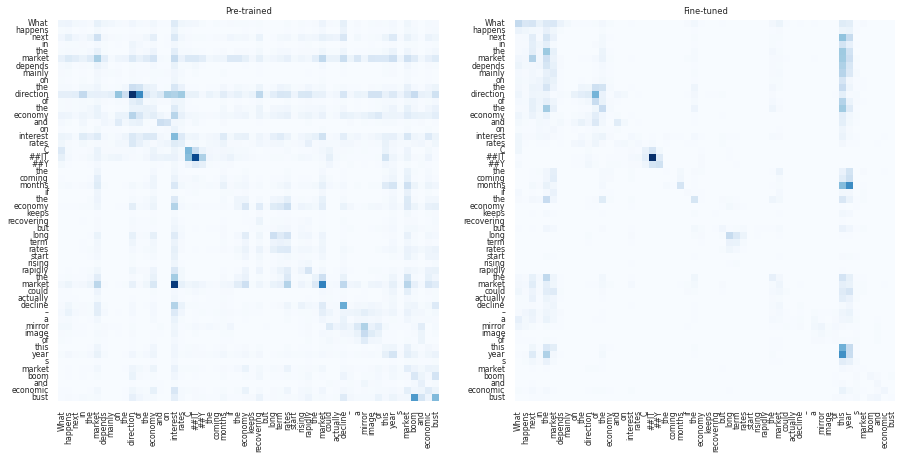

In [12]:
idx = 135
layer, head = 12, 2
ba, ip = sample(base_attentions, input_ids, idx)
fa, ip = sample(coarse_attentions, input_ids, idx)
tokens = tokenizer.convert_ids_to_tokens(ip)
sns.set(font_scale=font_scale)
plt.rcParams['figure.figsize'] = figure_size
fig, axes = plt.subplots(1, 2)
sns.heatmap(ba[layer-1, head-1], ax=axes[0], cmap="Blues", xticklabels=tokens, yticklabels=tokens, cbar=cbar)
axes[0].set_title('Pre-trained')
sns.heatmap(fa[layer-1, head-1], ax=axes[1], cmap="Blues", xticklabels=tokens, yticklabels=tokens, cbar=cbar)
axes[1].set_title('Fine-tuned')
plt.show()